# Hubbard One Approximation

### Structure of notebook

1. Parameters of the cattering region are defined.
2. Parameters of the fermi dirac function & Integration interval are defined.
3. Electron Density is self-consistently calculated
4. The magnetocurrent $\Delta I(m,V) = I(m) = I(-m)$ is calculated.
5. P value is calculated

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Path to modules

In [2]:
import sys

# sys.path.insert(0, '<path_to_modules>')

# Chiral Scattering Region

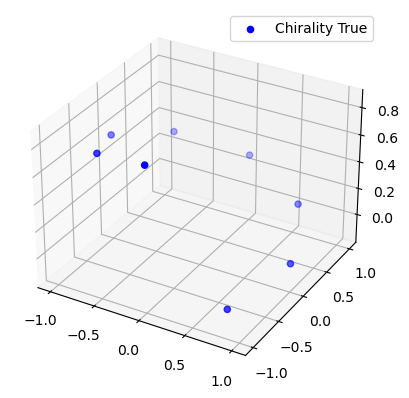

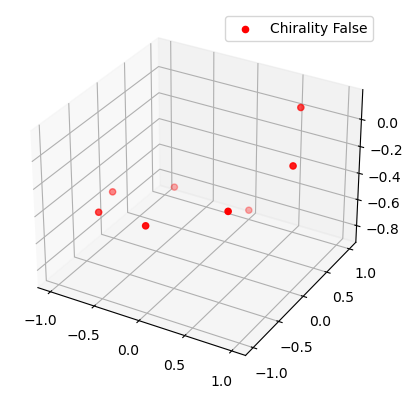

In [3]:
import ChiralChainModel_git
import Geometry_Git
Geometry_Git.plot3d_chain(a=1,c=1,M=1,N=8)

# Import NEGF methods

In [4]:
import negf_HIA_git

In [5]:
import Integration_HIA_Trapz_git

# 1. Defining Hamiltonian, Leads

In [6]:
Lm = 8             #number of sites 
chirality = True   #handedness of molecule 
N = Lm             # Number of sites within one winding
M = 1              # Number of windings
a = 1              # radius of helix
c = 1              # pitch of helix


epsilon = 0 # onsite energy
t = 2.4     # hopping paramter

# List of Spin-Orbit Coupling parameter used in publication
lambdalist = [(1*(10**-1))*t,(1*(10**-3))*t]
# List of interaction strengths used in publication
Ulist = [ 2*t, 0.5*t] 


#Gamma Matrix
kmax  = 4      # Number spin up + down sites coupled to each lead
gamma = 0.5    # coupling strength
pz    = 0.5    # magnetic polarization

pz_P = abs(pz)
pz_M = -abs(pz)


T = 300 # Kelvin Temperature of leads
betaL,betaR = negf_HIA_git.func_beta(T), negf_HIA_git.func_beta(T) # 1/ElectronVolt



# 2.  Bias window

In [7]:
Vmax = 3  # Maximum bias voltage [eV]
dV = 0.75 # stepsize
V_list_total = np.arange(-Vmax,Vmax + dV,dV)

In [8]:
print(V_list_total)

[-3.   -2.25 -1.5  -0.75  0.    0.75  1.5   2.25  3.  ]


# 2. Fermi Energy, Energies to integrate over

In [9]:
def func_energies(Hamiltonian0,U,npoints):
    '''
    Input:
    Hamiltonian0 = molecule without interaction (U=0)
    U = interaction strength
    npoints = number of energy points in window [emin,emax]
    Output:
    emax = upper bound of intergral
    emin = lowest eigenvalue of Hamiltonian0
    energiesreal = list of energies between [emin-1000,emax] (make sure the emax < ef +Vmax/2)
    eflist = list of fermi energies for which to calculate electron densities.
    '''
    evlist = np.linalg.eigh(Hamiltonian0)[0]
    e_lumo = evlist[int(Hamiltonian0.shape[0]/2)-1]
    e_homo = evlist[int(Hamiltonian0.shape[0]/2)]
    #Fermi Energy
    hl_gap = e_lumo - e_homo
    
    
    
    #lower,upper bound for Glesser function
    emin = np.round(int(10*min(evlist))/10 - 10,2) #lower bound for integrals
    emax = np.round(int(10*max(evlist))/10 + 10,2)   #lower bound for integrals
    
    
    energies_zero4000 = np.linspace(emin-1000,emin,2000)
   
    energiesreal_prime = np.linspace(emin,emax,npoints)
    
    energiesreal = Integration_HIA_Trapz_git.jointwolist(energies_zero4000,energiesreal_prime)
    

#     eflist = [U/2 + abs(np.round( 0  + kappa*hl_gap/2,11)) for kappa in [0.25] ]

    eflist = [ U/2 ]
    
    return emin,emax,npoints,energiesreal,eflist

# 2. Energes to integrate over

Comment on the convergence: Hubbard One converges well for big $U$ $(U > t)$.

In [10]:
tol = 10**-5
max_iteration = 50

npoints = 6000

#### Set Coulomb interaction strength and SOC paramter

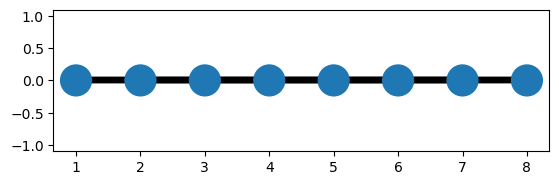

In [11]:
U       = Ulist[0]
lambda1 = lambdalist[0]

GammaR,GammaLP,GammaLM,Hamiltonian0,hamiltonian_shape= ChiralChainModel_git.system_hamiltonian0(Lm,
                                                                                    epsilon,t, 
                                                                              lambda1,chirality,
                                                                              a,c,M,N,
                                                                                kmax,gamma,abs(pz)
                                                                            )


emin,emax,npoints,energiesreal,eflist = func_energies(Hamiltonian0,U,npoints)

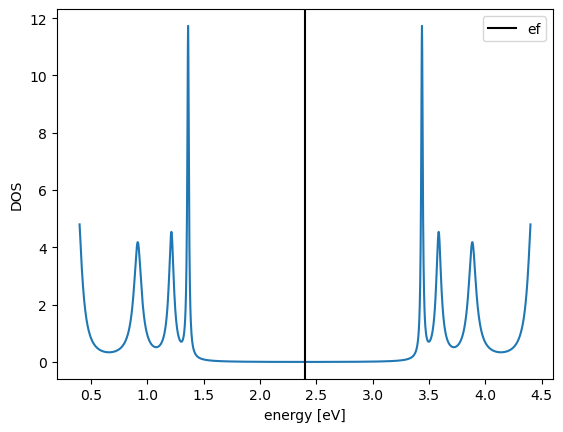

In [12]:
# DOS plot to see that ef is in between the HOMO,LUMO level:
Integration_HIA_Trapz_git.plot_DOS([0],
                                   [Integration_HIA_Trapz_git.nlist0_helicene(Hamiltonian0)],
eflist[0],U,Hamiltonian0, GammaLP,GammaR,0,False)

# 3. Electron Densities

Note: Hubbard One converges well for large U 

In [13]:


for i in range(len(eflist)):
    ef = eflist[i]


    n_list_totalP,convglistP = Integration_HIA_Trapz_git.self_consistent_trapz(V_list_total,Vmax,
                                      max_iteration,
                            ef,
                                    U,
                                    Hamiltonian0,
                                    GammaLP,GammaR, 
                                    betaL, betaR,tol,energiesreal)


    n_list_totalM,convglistM = Integration_HIA_Trapz_git.self_consistent_trapz(V_list_total,Vmax, 
                                  max_iteration,
                        ef,
                                U,
                                Hamiltonian0,
                                GammaLM,GammaR, 
                                betaL, betaR,tol,energiesreal)


    V_list_convg,nP_list_convg,nM_list_convg =  Integration_HIA_Trapz_git.converged_lists(V_list_total,
                                                              n_list_totalP ,convglistP,
                                                              n_list_totalM, convglistM)

--- V = -3.0 ---
[0.01016 0.01499 0.00986 0.0304  0.01215 0.01885 0.01678 0.01784 0.00758
 0.02524 0.01011 0.01959 0.01867 0.0207  0.00643 0.01532]
[6.30e-04 5.80e-04 3.44e-03 2.11e-03 7.89e-03 4.86e-03 3.90e-04 9.90e-04
 3.15e-03 2.44e-03 7.81e-03 4.42e-03 9.00e-05 8.50e-04 1.80e-03 2.28e-03]
[0.00098 0.00024 0.00056 0.0005  0.00188 0.00329 0.00059 0.00068 0.00071
 0.00053 0.00177 0.0031  0.00064 0.00057 0.0006  0.00101]
[2.30e-04 6.70e-04 1.00e-05 3.20e-04 1.39e-03 7.50e-04 4.10e-04 1.10e-04
 9.00e-05 3.40e-04 1.26e-03 7.00e-04 3.50e-04 1.50e-04 7.40e-04 2.80e-04]
[4.1e-04 2.4e-04 1.6e-04 6.0e-05 3.3e-04 6.1e-04 4.0e-05 1.6e-04 1.2e-04
 2.0e-05 2.9e-04 5.4e-04 6.0e-05 2.0e-04 8.0e-05 4.9e-04]
[1.5e-04 2.4e-04 7.0e-05 1.1e-04 2.8e-04 1.6e-04 9.0e-05 1.0e-05 1.0e-05
 5.0e-05 2.5e-04 1.2e-04 1.3e-04 1.0e-05 2.9e-04 3.0e-05]
[1.4e-04 1.1e-04 6.0e-05 5.0e-05 8.0e-05 1.3e-04 1.0e-05 4.0e-05 1.0e-05
 1.0e-05 5.0e-05 1.2e-04 0.0e+00 8.0e-05 1.0e-05 1.7e-04]
[6.e-05 8.e-05 3.e-05 4.e-05 6.e-0

[3.5e-04 1.2e-04 3.0e-04 1.0e-04 0.0e+00 0.0e+00 1.0e-05 0.0e+00 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 2.0e-04 2.0e-04 2.4e-04 2.4e-04]
[9.0e-05 2.6e-04 6.0e-05 1.8e-04 1.0e-05 2.0e-05 0.0e+00 1.0e-05 0.0e+00
 1.0e-05 1.0e-05 1.0e-05 1.2e-04 1.2e-04 1.7e-04 1.7e-04]
[1.9e-04 7.0e-05 1.0e-04 4.0e-05 2.0e-05 1.0e-05 1.0e-05 0.0e+00 1.0e-05
 0.0e+00 1.0e-05 1.0e-05 7.0e-05 7.0e-05 1.3e-04 1.3e-04]
[5.0e-05 1.4e-04 2.0e-05 6.0e-05 1.0e-05 2.0e-05 0.0e+00 1.0e-05 0.0e+00
 1.0e-05 1.0e-05 1.0e-05 4.0e-05 4.0e-05 1.0e-04 1.0e-04]
[1.1e-04 4.0e-05 3.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 0.0e+00 1.0e-05
 0.0e+00 1.0e-05 1.0e-05 2.0e-05 2.0e-05 7.0e-05 7.0e-05]
[3.e-05 8.e-05 0.e+00 1.e-05 0.e+00 1.e-05 0.e+00 1.e-05 0.e+00 0.e+00
 1.e-05 1.e-05 1.e-05 1.e-05 6.e-05 6.e-05]
[6.e-05 2.e-05 0.e+00 0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 1.e-05 1.e-05 0.e+00 0.e+00 4.e-05 4.e-05]
[2.e-05 5.e-05 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 3.e-05 3.e-05]


[6.e-05 1.e-05 2.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00
 0.e+00 1.e-05 1.e-05 2.e-05 3.e-05 5.e-05]
[0.e+00 5.e-05 0.e+00 2.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 2.e-05 1.e-05 4.e-05 2.e-05]
[3.e-05 0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 1.e-05 1.e-05 2.e-05 3.e-05]
[0.e+00 3.e-05 0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 1.e-05 1.e-05 2.e-05 1.e-05]
[2.e-05 0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 1.e-05 1.e-05 2.e-05]
[0.e+00 1.e-05 0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 1.e-05 0.e+00 1.e-05 1.e-05]
[1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 1.e-05]
[0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00]
[1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0

[9.0e-05 3.0e-04 5.0e-05 5.0e-05 2.2e-04 8.0e-05 1.8e-04 3.0e-05 1.0e-04
 4.0e-05 1.0e-04 7.0e-05 5.0e-05 5.0e-05 3.0e-04 2.1e-04]
[2.4e-04 6.0e-05 2.0e-05 3.0e-05 6.0e-05 1.5e-04 2.0e-05 1.1e-04 3.0e-05
 6.0e-05 5.0e-05 6.0e-05 2.0e-05 1.0e-05 1.6e-04 2.3e-04]
[5.0e-05 1.8e-04 3.0e-05 0.0e+00 1.0e-04 4.0e-05 7.0e-05 1.0e-05 3.0e-05
 2.0e-05 4.0e-05 3.0e-05 1.0e-05 1.0e-05 1.8e-04 1.2e-04]
[1.4e-04 3.0e-05 1.0e-05 2.0e-05 3.0e-05 7.0e-05 1.0e-05 4.0e-05 1.0e-05
 2.0e-05 2.0e-05 3.0e-05 0.0e+00 2.0e-05 1.0e-04 1.4e-04]
[2.0e-05 1.1e-04 1.0e-05 1.0e-05 5.0e-05 2.0e-05 2.0e-05 0.0e+00 1.0e-05
 1.0e-05 2.0e-05 1.0e-05 2.0e-05 1.0e-05 1.1e-04 7.0e-05]
[9.e-05 2.e-05 2.e-05 1.e-05 1.e-05 3.e-05 0.e+00 1.e-05 0.e+00 0.e+00
 1.e-05 2.e-05 1.e-05 2.e-05 6.e-05 9.e-05]
[1.e-05 7.e-05 1.e-05 1.e-05 2.e-05 1.e-05 1.e-05 0.e+00 0.e+00 0.e+00
 1.e-05 0.e+00 2.e-05 1.e-05 7.e-05 5.e-05]
[5.e-05 1.e-05 1.e-05 0.e+00 0.e+00 2.e-05 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 1.e-05 1.e-05 2.e-05 4.e-05 5.e-05]


[2.e-05 6.e-05 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00
 1.e-05 1.e-05 0.e+00 0.e+00 4.e-05 4.e-05]
[5.e-05 1.e-05 0.e+00 0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 3.e-05 3.e-05]
[1.e-05 4.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 2.e-05 2.e-05]
[3.e-05 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 2.e-05 2.e-05]
[1.e-05 2.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 1.e-05]
[2.e-05 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 1.e-05]
[0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 1.e-05]
[1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 1.e-05]
[0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0

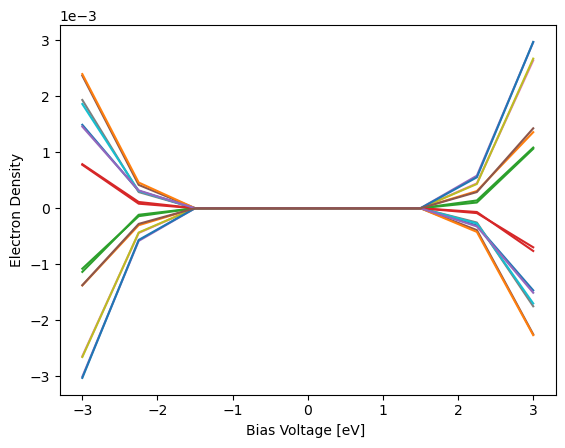

In [14]:
n_list_total_convgM_swap = [negf_HIA_git.pairwise_swap(nM_list_convg[i]) for i in range(len(nM_list_convg))]

plt.plot(V_list_convg,np.subtract(nP_list_convg,n_list_total_convgM_swap))
plt.xlabel('Bias Voltage [eV] ')
plt.ylabel('Electron Density')
plt.ticklabel_format(style="sci", scilimits=(0,0))


plt.show()

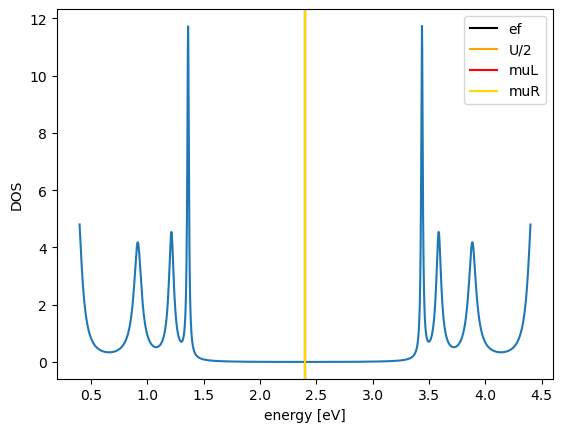

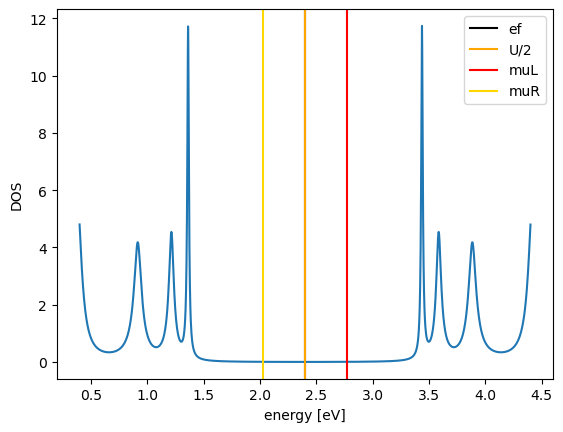

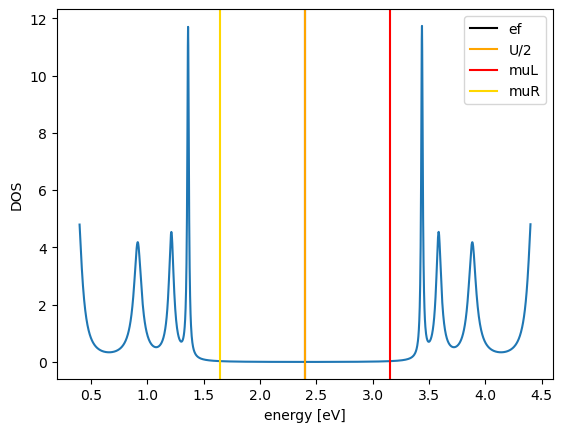

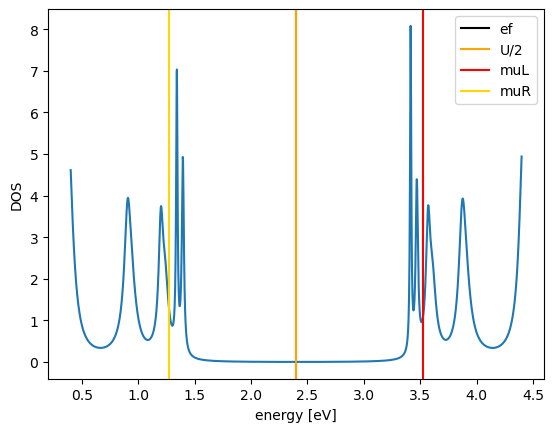

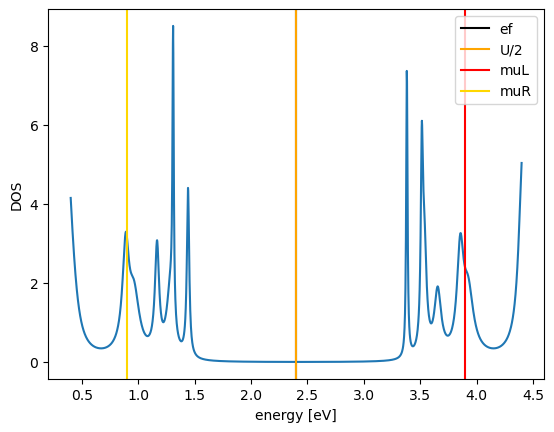

In [15]:
Integration_HIA_Trapz_git.plot_DOS(V_list_convg,nP_list_convg,
             ef,U,
             Hamiltonian0,GammaLP,GammaR,
             4,True)

# 4. Magnetocurrent

In [16]:
import Currents_HIA_git

In [17]:
dI_list_quad,dI_list_error = Currents_HIA_git.calc_deltaI_quad(V_list_convg,
                       eflist[0],
                        Hamiltonian0 ,
                          GammaLP,GammaR,
                          GammaLM,
                          U,nP_list_convg, nM_list_convg,
                          betaL,betaR)

--- V = -3.0 ---
--- V = -2.25 ---
--- V = -1.5 ---
--- V = -0.75 ---
--- V = 0.0 ---
--- V = 0.75 ---
--- V = 1.5 ---
--- V = 2.25 ---
--- V = 3.0 ---


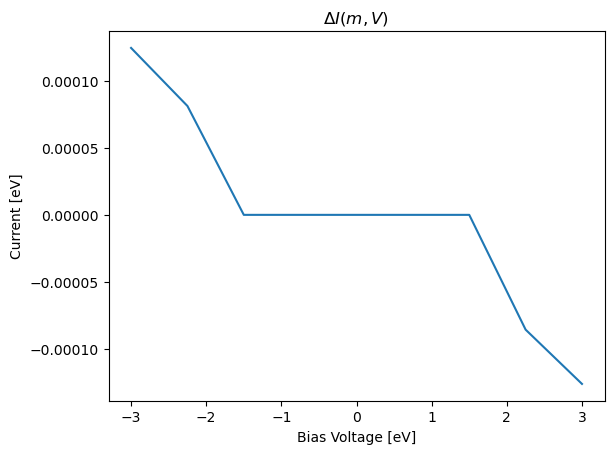

In [18]:
plt.title('$\Delta I(m,V)$')
plt.plot(V_list_convg,dI_list_quad)
plt.xlabel('Bias Voltage [eV]')
plt.ylabel('Current [eV]')
plt.show()

# 5. P Value

In [19]:
import Pvalue

In [20]:
Vlist_prime,PJ_list = Pvalue.function_PvaluedI(V_list_convg,dI_list_quad,12)

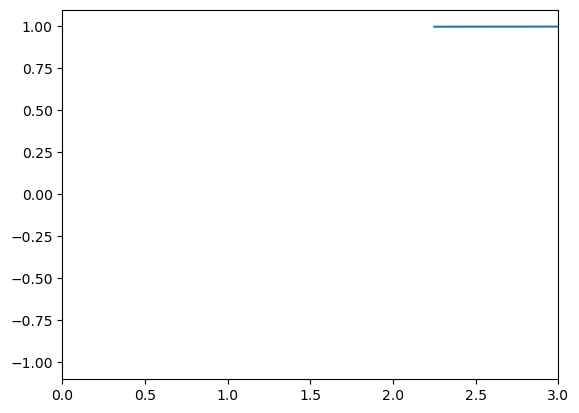

In [21]:
plt.plot(Vlist_prime,PJ_list)
plt.xlim(0,Vmax)
plt.ylim(-1-0.1,1+0.1)
plt.xlabel('Bias Voltage [eV]')
plt.ylabel('P')
plt.show()